In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt
import string
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

df = pd.read_csv('20newsgroups.csv', names=['Text','Label'], skiprows=1)

c:\Users\Axioo Pongo\anaconda3\envs\Stable\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df.head()

,Text,Label
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4


In [3]:
def simplify_text(email_text):
    def extract_body(email_text):
        parts = email_text.split('\n\n', 1)
        if len(parts) > 1:
            body = parts[1].strip()
            body = re.split(r'\n--', body, maxsplit=1)[0].strip()
            body = body.replace('\n', ' ')
            return body
        return email_text

    def remove_before_writes(text):
        if "writes:" in text:
            return text.rsplit("writes:",1)[1].strip()
        if "says:" in text:
            return text.rsplit("says:",1)[1].strip()
        if "wrote:" in text:
            return text.rsplit("wrote:",1)[1].strip()
        return text

    def remove_before_edu(text):
        if ".edu," in text:
            return text.split(".edu,")[1].strip()
        return text

    def clean_repeated_punctuation_and_spaces(text):
        cleaned_text = re.sub(r'([.,!?;:-])\1+', r'\1', text)
        # Replace multiple spaces with a single space
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
        # Strip leading and trailing spaces
        cleaned_text = cleaned_text.strip()
        return cleaned_text
    
    def remove_punctuation(text):
        return text.translate(str.maketrans('', '', string.punctuation.replace('.', '').replace(',', '').replace('?', '').replace('!', '')))

    def remove_websites_with_specific_domains(text):
        website_pattern = r'\S+(\.com|\.edu|\.org)\b|\bwww\.\S+?(\.com|\.edu|\.EDU|\.org)\b'
        # Menghapus URL dari teks
        return re.sub(website_pattern, '', text, flags=re.IGNORECASE).strip()
    
    def remove_punctuation_start(text):
        return re.sub(r'^[^\w\s]+', '', text)

    email_text = extract_body(email_text)
    email_text = remove_before_writes(email_text)
    email_text = remove_before_edu(email_text)
    email_text = remove_punctuation(email_text)
    email_text = clean_repeated_punctuation_and_spaces(email_text)
    email_text = remove_websites_with_specific_domains(email_text)
    email_text = remove_punctuation_start(email_text)
    return email_text

# Terapkan fungsi simplify_text ke kolom 'Text'
df['Text'] = df['Text'].apply(simplify_text)
df = df[df['Text'] != ''].drop(columns=['Label'])

In [4]:
# doc_lengths = []

# for bio in df['Text']:

#     # get rough token count distribution
#     tokens = nltk.word_tokenize(bio)

#     doc_lengths.append(len(tokens))

# doc_lengths = np.array(doc_lengths)

# plt.figure(figsize=(15, 4))
# sns.histplot(doc_lengths, kde=True)
# plt.xlabel('Document Length')
# plt.ylabel('Frequency')
# plt.title('Distribution of Document Lengths')
# plt.show()

In [5]:
# len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

In [6]:
# doc_lengths.mean()

In [7]:
from datasets import Dataset
df = Dataset.from_pandas(df)

pretrained = 'EleutherAI/gpt-neo-125m'
config = AutoConfig.from_pretrained(pretrained)
model = AutoModelForCausalLM.from_pretrained(pretrained, config=config)
tokenizer = AutoTokenizer.from_pretrained(pretrained)
tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    tokenized = tokenizer(
        examples["Text"], 
        padding="max_length", 
        truncation=True, 
        max_length=256,
        return_tensors="pt" )

    tokenized["labels"] = tokenized["input_ids"].clone()

    return tokenized

# Tokenize the dataset
tokenized_dataset = df.map(tokenize_function, batched=True)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

c:\Users\Axioo Pongo\anaconda3\envs\Stable\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Axioo Pongo\.cache\huggingface\hub\models--EleutherAI--gpt-neo-125m. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Map: 100%|██████████| 18807/18807 [00:03<00:00, 5757.95 examples/s]


In [8]:
split_datasets = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

train_val_split = split_datasets["train"].train_test_split(test_size=0.125, seed=42)  # 0.125 = 10% dari keseluruhan data

train_dataset = train_val_split["train"]
val_dataset = split_datasets["test"]
test_dataset = train_val_split["test"]

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 13164
Validation dataset size: 3762
Test dataset size: 1881


In [9]:
from transformers import Trainer, TrainingArguments

# Define training arguments
args = TrainingArguments(
    output_dir='./results neo',
    num_train_epochs=10,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    learning_rate=1e-5,
    fp16=True,
    logging_dir='./logs neo',          # Directory to save logs
    logging_strategy="epoch",      # Log after each epoch
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

 10%|█         | 1097/10970 [06:30<1:00:01,  2.74it/s]

{'loss': 2.6168, 'grad_norm': 2.1803090572357178, 'learning_rate': 9.003646308113036e-06, 'epoch': 1.0}


                                                      
 10%|█         | 1097/10970 [07:35<1:00:01,  2.74it/s]

{'eval_loss': 2.5064589977264404, 'eval_runtime': 65.4066, 'eval_samples_per_second': 57.517, 'eval_steps_per_second': 57.517, 'epoch': 1.0}


 20%|██        | 2194/10970 [14:13<53:43,  2.72it/s]   

{'loss': 2.4618, 'grad_norm': 1.7118866443634033, 'learning_rate': 8.003646308113037e-06, 'epoch': 2.0}


                                                    
 20%|██        | 2194/10970 [15:19<53:43,  2.72it/s]

{'eval_loss': 2.469975233078003, 'eval_runtime': 66.6782, 'eval_samples_per_second': 56.42, 'eval_steps_per_second': 56.42, 'epoch': 2.0}


 30%|███       | 3291/10970 [21:58<46:05,  2.78it/s]   

{'loss': 2.4024, 'grad_norm': 1.9296928644180298, 'learning_rate': 7.003646308113036e-06, 'epoch': 3.0}


                                                    
 30%|███       | 3291/10970 [23:03<46:05,  2.78it/s]

{'eval_loss': 2.4487814903259277, 'eval_runtime': 65.2027, 'eval_samples_per_second': 57.697, 'eval_steps_per_second': 57.697, 'epoch': 3.0}


 40%|████      | 4388/10970 [29:42<39:55,  2.75it/s]   

{'loss': 2.3575, 'grad_norm': 2.11039662361145, 'learning_rate': 6.003646308113036e-06, 'epoch': 4.0}


                                                    
 40%|████      | 4388/10970 [30:48<39:55,  2.75it/s]

{'eval_loss': 2.433107376098633, 'eval_runtime': 66.3703, 'eval_samples_per_second': 56.682, 'eval_steps_per_second': 56.682, 'epoch': 4.0}


 50%|█████     | 5485/10970 [37:28<32:59,  2.77it/s]   

{'loss': 2.3211, 'grad_norm': 1.9702569246292114, 'learning_rate': 5.003646308113036e-06, 'epoch': 5.0}


                                                    
 50%|█████     | 5485/10970 [38:34<32:59,  2.77it/s]

{'eval_loss': 2.4233670234680176, 'eval_runtime': 66.5054, 'eval_samples_per_second': 56.567, 'eval_steps_per_second': 56.567, 'epoch': 5.0}


 60%|██████    | 6582/10970 [45:13<26:22,  2.77it/s]   

{'loss': 2.2923, 'grad_norm': 1.7975871562957764, 'learning_rate': 4.004557885141295e-06, 'epoch': 6.0}


                                                    
 60%|██████    | 6582/10970 [46:19<26:22,  2.77it/s]

{'eval_loss': 2.415748357772827, 'eval_runtime': 66.2492, 'eval_samples_per_second': 56.786, 'eval_steps_per_second': 56.786, 'epoch': 6.0}


 70%|███████   | 7679/10970 [52:58<19:52,  2.76it/s]   

{'loss': 2.269, 'grad_norm': 1.936287760734558, 'learning_rate': 3.004557885141295e-06, 'epoch': 7.0}


                                                    
 70%|███████   | 7679/10970 [54:04<19:52,  2.76it/s]

{'eval_loss': 2.410916328430176, 'eval_runtime': 66.0803, 'eval_samples_per_second': 56.931, 'eval_steps_per_second': 56.931, 'epoch': 7.0}


 80%|████████  | 8776/10970 [1:00:43<13:12,  2.77it/s] 

{'loss': 2.2513, 'grad_norm': 1.8988652229309082, 'learning_rate': 2.0045578851412947e-06, 'epoch': 8.0}


                                                      
 80%|████████  | 8776/10970 [1:01:48<13:12,  2.77it/s]

{'eval_loss': 2.4071648120880127, 'eval_runtime': 65.8806, 'eval_samples_per_second': 57.103, 'eval_steps_per_second': 57.103, 'epoch': 8.0}


 90%|█████████ | 9873/10970 [1:08:27<06:35,  2.77it/s]   

{'loss': 2.2388, 'grad_norm': 1.8194315433502197, 'learning_rate': 1.0045578851412945e-06, 'epoch': 9.0}


                                                      
 90%|█████████ | 9873/10970 [1:09:33<06:35,  2.77it/s]

{'eval_loss': 2.4054057598114014, 'eval_runtime': 66.1403, 'eval_samples_per_second': 56.879, 'eval_steps_per_second': 56.879, 'epoch': 9.0}


100%|██████████| 10970/10970 [1:16:14<00:00,  2.77it/s] 

{'loss': 2.2311, 'grad_norm': 1.8621389865875244, 'learning_rate': 4.557885141294439e-09, 'epoch': 10.0}


                                                       
100%|██████████| 10970/10970 [1:17:20<00:00,  2.77it/s]

{'eval_loss': 2.4050095081329346, 'eval_runtime': 66.6018, 'eval_samples_per_second': 56.485, 'eval_steps_per_second': 56.485, 'epoch': 10.0}


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].
100%|██████████| 10970/10970 [1:17:22<00:00,  2.36it/s]

{'train_runtime': 4642.852, 'train_samples_per_second': 28.353, 'train_steps_per_second': 2.363, 'train_loss': 2.3441988671162832, 'epoch': 10.0}


TrainOutput(global_step=10970, training_loss=2.3441988671162832, metrics={'train_runtime': 4642.852, 'train_samples_per_second': 28.353, 'train_steps_per_second': 2.363, 'total_flos': 1.719265114718208e+16, 'train_loss': 2.3441988671162832, 'epoch': 10.0})

In [10]:
# Evaluate BLEU score on train dataset

model = model.to("cuda")
train_results = trainer.evaluate(eval_dataset=train_dataset, metric_key_prefix="train")
val_results = trainer.evaluate(eval_dataset=val_dataset, metric_key_prefix="val")
test_results = trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

print(f"Train loss      : {train_results['train_loss']}")
print(f"Validation loss : {val_results['val_loss']}")
print(f"Test loss       : {test_results['test_loss']}")

100%|██████████| 1881/1881 [00:34<00:00, 55.06it/s]

Train loss      : 2.2284820079803467
Validation loss : 2.4050095081329346
Test loss       : 2.444209337234497


In [11]:
import math

def calculate_ppl(loss):
    return math.exp(loss)

train_ppl = calculate_ppl(train_results['train_loss'])
val_ppl = calculate_ppl(val_results['val_loss'])
test_ppl = calculate_ppl(test_results['test_loss'])

print(f"Train PPL       : {train_ppl}")
print(f"Validation PPL  : {val_ppl}")
print(f"Test PPL        : {test_ppl}")

Train PPL       : 9.285759666411103
Validation PPL  : 11.078535617875026
Test PPL        : 11.521436425803318


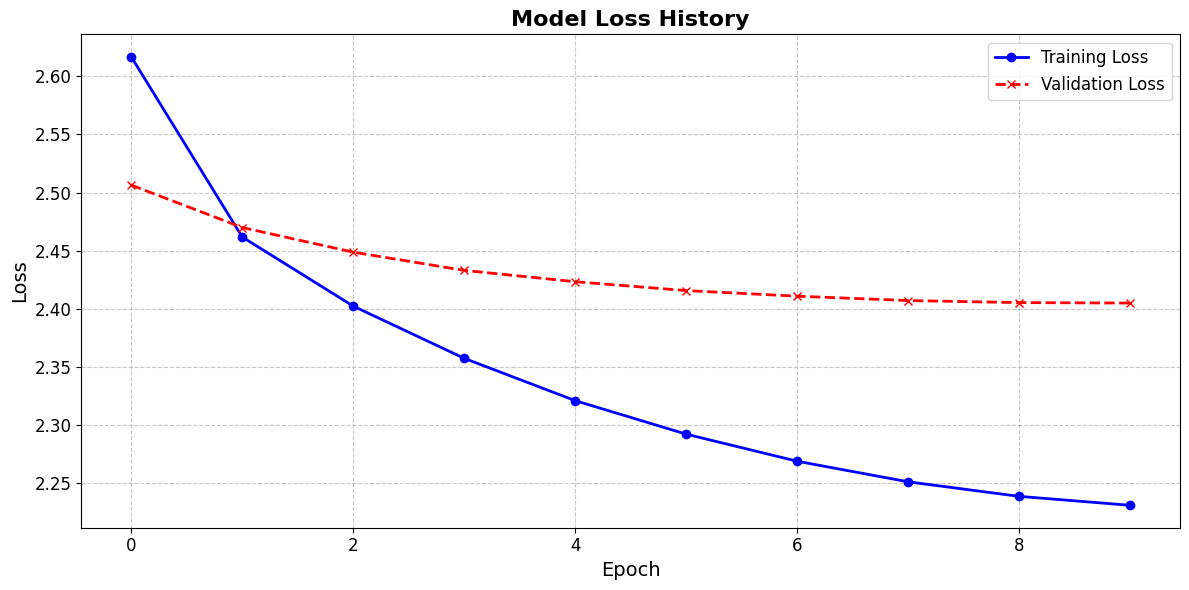

In [12]:
# Extract loss values from the log history
train_loss_values = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss_values = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Plot the loss values
plt.figure(figsize=(12, 6))
plt.plot(train_loss_values, label='Training Loss', marker='o', linestyle='-', color='b', linewidth=2, markersize=6)
plt.plot(eval_loss_values, label='Validation Loss', marker='x', linestyle='--', color='r', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Model Loss History', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [13]:
# Generate text
input_text = "dont know what to say"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

# Generate sequences
model = model.to("cpu")
output = model.generate(input_ids, max_length=50, num_return_sequences=1, 
                        attention_mask=tokenizer(input_text, return_tensors="pt").attention_mask, do_sample=True,
                        no_repeat_ngram_size=2, top_k=50, top_p=0.95, temperature=0.7, early_stopping=True, num_beams=2)
generated_text = tokenizer.decode(output[0], skip_special_tokens=True,)

# Print generated text until the first period
print("Input Text       :", input_text)
print("Generated Text   :", generated_text.rsplit('.', 1)[0] + '.')

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Input Text       : dont know what to say
Generated Text   : dont know what to say. I dont think that you should be trying to get into the middle of something that has nothing to do with the subject of this thread.
